In [39]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

In [26]:
import seaborn as sns

In [3]:
ls = pd.read_csv("ladestationen.csv")
st = pd.read_csv("stadtteile.csv")

In [5]:
st["Bedarf"].sum()

311.49

<AxesSubplot:xlabel='x', ylabel='y'>

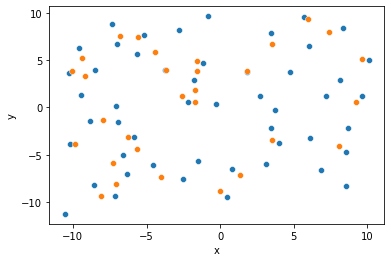

In [30]:
sns.scatterplot(x=ls["x"], y=ls["y"])
sns.scatterplot(x=st["x"], y=st["y"])

In [33]:
st.shape

(30, 5)

In [32]:
ls.shape

(50, 4)

In [38]:
c = 
r = st

In [71]:
def dist(i,j):
    return np.sqrt((ls.iloc[i].x-st.iloc[j].x)**2 + (ls.iloc[i].y-st.iloc[j].y)**2)

dist(0,0)


1.8418997979519722

In [76]:
m_dist = np.fromfunction(np.vectorize(dist), (44,11), dtype=int)

In [78]:
m_dist

array([[ 1.8418998 , 11.67449556,  8.24929597,  7.91832737,  8.26848082,
         2.11190568,  7.45608804, 10.46635889, 10.10531592,  5.90859352,
        12.08245498],
       [ 9.7858506 ,  4.61898952, 14.01216492, 17.01993407,  5.88040643,
         9.49454608, 15.35884571, 10.16250966,  8.23184099, 14.18994098,
         5.35393789],
       [ 7.56000842, 18.07938046,  2.01018073, 12.31823215,  8.52121479,
        11.46017331,  5.88853983,  5.96435992, 18.66920758, 13.54576767,
        12.78618938],
       [ 6.50467129, 18.21477349,  8.83083632,  1.55637276, 14.13965823,
         7.05581699,  5.27072634, 14.80326973, 15.4560325 ,  4.55356982,
        18.43366694],
       [ 9.00446538,  6.80274471, 15.30336043, 13.07312292, 11.30673972,
         5.77570092, 14.66030289, 15.13939397,  2.90648269,  9.04327579,
        12.81898748],
       [ 9.1819064 , 12.79803327,  8.9449589 , 16.77716127,  2.52929058,
        11.86475712, 12.05466754,  2.17626327, 15.52533261, 15.94918428,
         5.262